# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [86]:
#see online at https://covid19-jyy3.onrender.com/analysis

In [87]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44110  100 44110    0     0   195k      0 --:--:-- --:--:-- --:--:--  195k


In [88]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Merge made by the 'recursive' strategy.
 CHANGELOG.md    | 22 ++++++++++------
 CHANGELOG_EN.md | 23 ++++++++++------
 README.md       | 82 ++++++++++++++++++++++++++++-----------------------------
 3 files changed, 70 insertions(+), 57 deletions(-)


In [89]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

In [90]:
#suppress annoying warnings about pandas assignment
pd.options.mode.chained_assignment = None
#suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [91]:
#format x axis with dates
def format_x_date(ax):
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin-1,xmax+1)
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    return xmin,xmax


def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color='#007acc', alpha=0.9,label='Ratio')
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color='#007acc', alpha=0.2, linewidth=5)

    #set ticks every week
    xmin,xmax=format_x_date(ax)
    ax.spines['bottom'].set_bounds(xmin+1, xmax-1)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ymin, ymax = ax.get_ylim()
    ax.spines['left'].set_bounds(0, ymax)
    return ax

def get_country_data(selection):
    selection = selection.iloc[:,4:].T
    selection.columns=['Death']
    selection['Death_change']=selection['Death']-selection['Death'].shift(1)
    selection=selection.reset_index()
    selection['index'] = pd.to_datetime(selection['index'])
    selection['Death_change_log']=np.log10(selection['Death_change'])
    selection['Death_change_log']=selection['Death_change_log'].replace(-np.inf,np.nan)
    selection=selection[~selection['Death_change_log'].isna()]
    selection.columns=['date']+list(selection.columns[1:])
    selection['ndate']=date2num(selection['date'])
    return selection



# Load national dataset

In [92]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_attualmente_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_attualmente_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,90,3.0,35,10,0.477121
2,74,2.0,36,12,0.301030
3,203,5.0,56,17,0.698970
4,233,4.0,64,21,0.602060


## Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

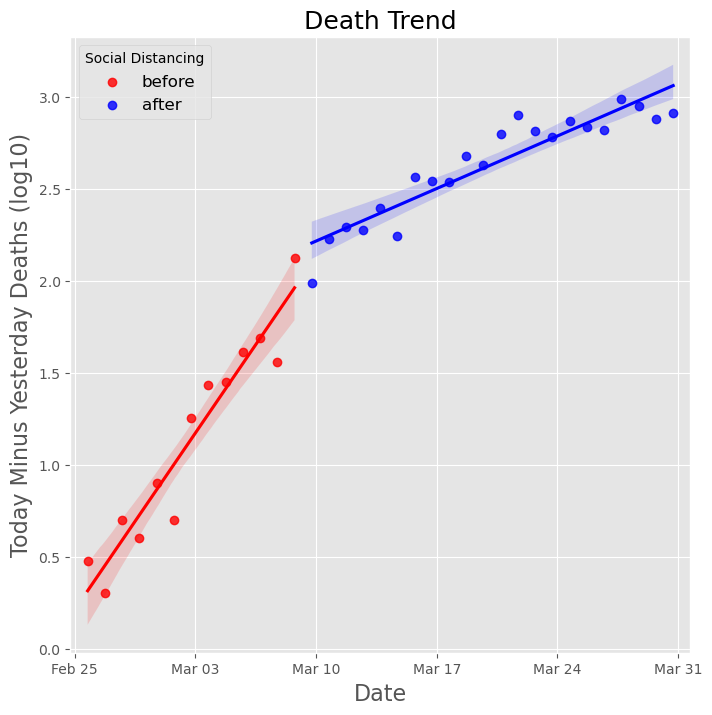

In [93]:
plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[df['data']>'2020-03-9']
after['ndata']=date2num(after['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='after')
_,_=format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2 
How many more people die in Italy respect to the people admitted in intensive care?

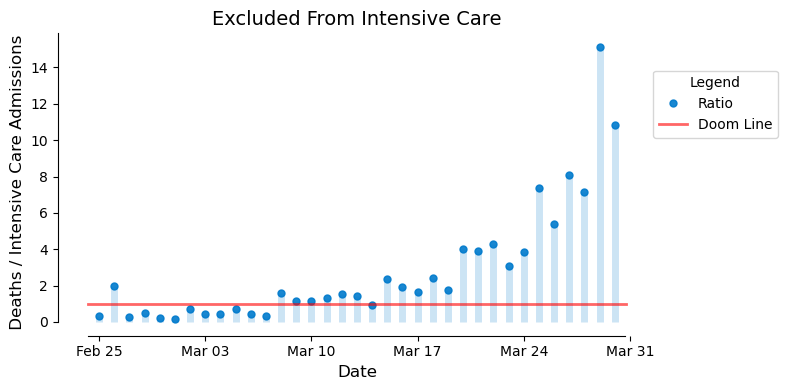

In [94]:
plt.style.use('default')

fig,ax=plt.subplots(figsize=(8,4))

ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted_ratio')

ax.axhline(1, xmin=0.05,xmax=0.95,
           linewidth=2,color='r',alpha=0.6,label='Doom Line')

plt.xlabel('Date', fontsize='12')
plt.ylabel(' Deaths / Intensive Care Admissions', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

## Fig3
How many people die in Italy without getting intensive care

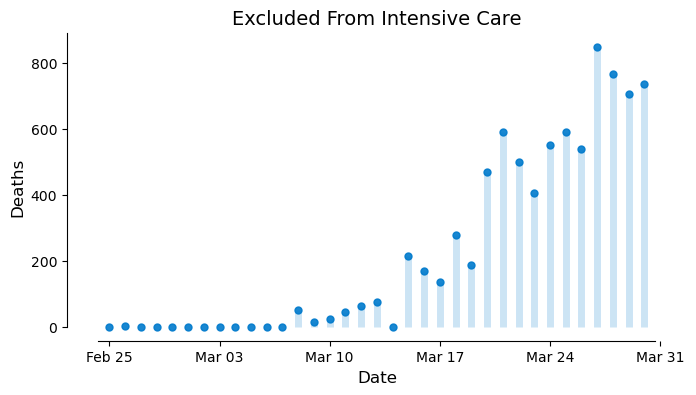

In [95]:
plt.style.use('default')
fig,ax=plt.subplots(figsize=(8,4))
df['not_admitted']=df['not_admitted'].clip(lower=0)
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='not_admitted')

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

## Extract UK data

In [96]:
allDf = pd.read_csv('deaths_global.csv')
temp = allDf[(allDf['Country/Region']=='United Kingdom') & (allDf['Lat']==55.3781)  ]
uk_df =  get_country_data(temp)   

## Fig4 
How the Italian and Spanish death trend compare to UK?

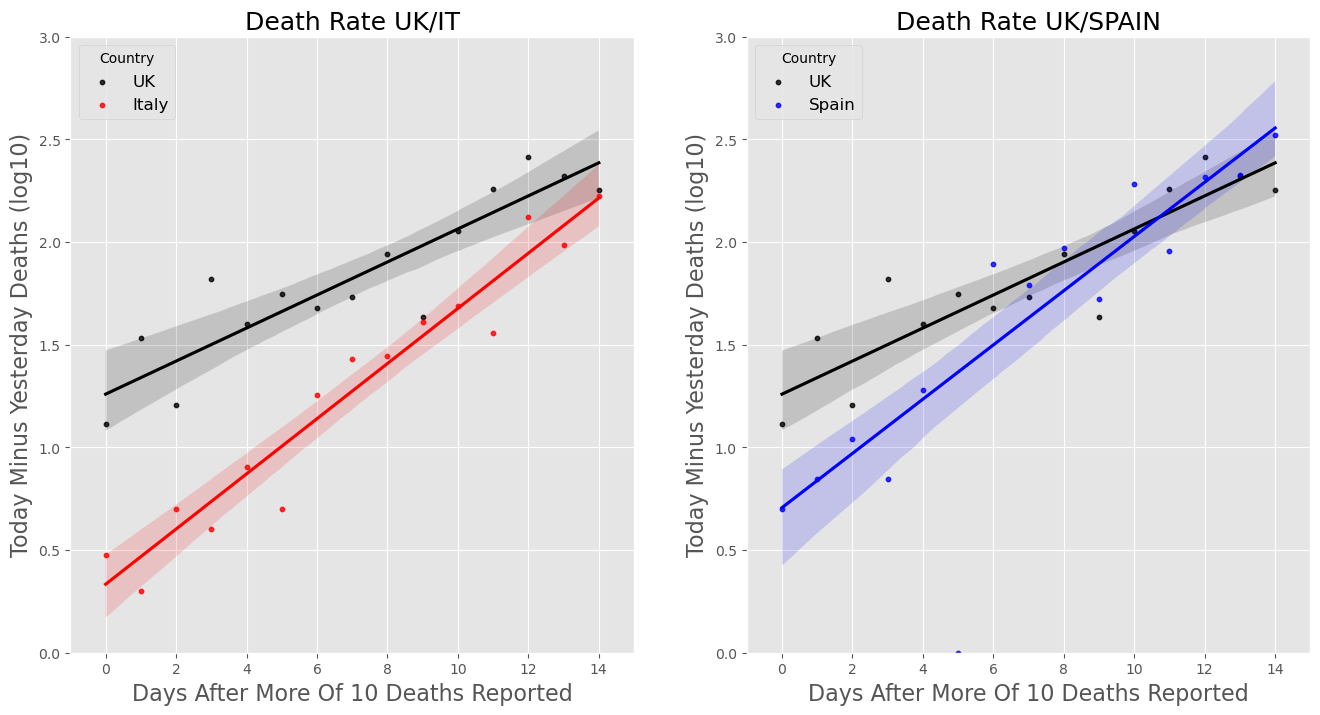

In [97]:
_DEATH_START=10

plt.style.use('ggplot')
fig,axes=plt.subplots(figsize=(16,8),ncols=2)
ax=axes[0]
y='Death_change_log'
uk_df=uk_df[uk_df['Death']>=_DEATH_START]
sns.regplot(x=np.arange(0,uk_df.shape[0]),
            y=y, color="black", data=uk_df,ax=ax,label='UK',
            scatter_kws={'s':10,'marker':'x'},robust=True)

y='deceduti_daily_log'
#temp = df[df['data']<'2020-03-13']
temp = df[~df[y].isna()]
temp = temp[temp['deceduti']>=_DEATH_START]
temp = temp.iloc[:uk_df.shape[0]]

sns.regplot(x=np.arange(0,temp.shape[0]),
            y=y, color="r", data=temp,ax=ax,
            label='Italy',scatter_kws={'s':10},robust=True)

ax.set_xlim(-1,uk_df.shape[0])
ax.set_xlabel('Days After More Of {_DEATH_START} Deaths Reported'.format(_DEATH_START=_DEATH_START)
              , fontsize='16')
ax.set_ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
ax.set_title('Death Rate UK/IT',fontsize='18')
ax.legend(title='Country',fontsize=12,loc=2)
ax.set_ylim(0,3)

temp = allDf[(allDf['Country/Region']=='Spain')]
spain_df =  get_country_data(temp)
spain_df=spain_df[spain_df['Death']>=_DEATH_START]
spain_df = spain_df.iloc[:uk_df.shape[0]]
ax=axes[1]
y='Death_change_log'
sns.regplot(x=np.arange(0,uk_df.shape[0]),
            y=y, color="black", data=uk_df,ax=ax,label='UK',
            scatter_kws={'s':10,'marker':'x'},robust=True)

sns.regplot(x=np.arange(0,spain_df.shape[0]),
            y=y, color="blue", data=spain_df,ax=ax,label='Spain',
            scatter_kws={'s':10,'marker':'x'},robust=True)


ax.set_xlim(-1,uk_df.shape[0])
ax.set_xlabel('Days After More Of {_DEATH_START} Deaths Reported'.format(_DEATH_START=_DEATH_START)
              , fontsize='16')
ax.set_ylabel('Today Minus Yesterday Deaths (log10)',fontsize='16')
ax.set_title('Death Rate UK/SPAIN',fontsize='18')
ax.legend(title='Country',fontsize=12,loc=2)
ax.set_ylim(0,3)
plt.savefig('Fig4.png')
plt.show()

## Fig5
How Italian and spansh death trend looks like?

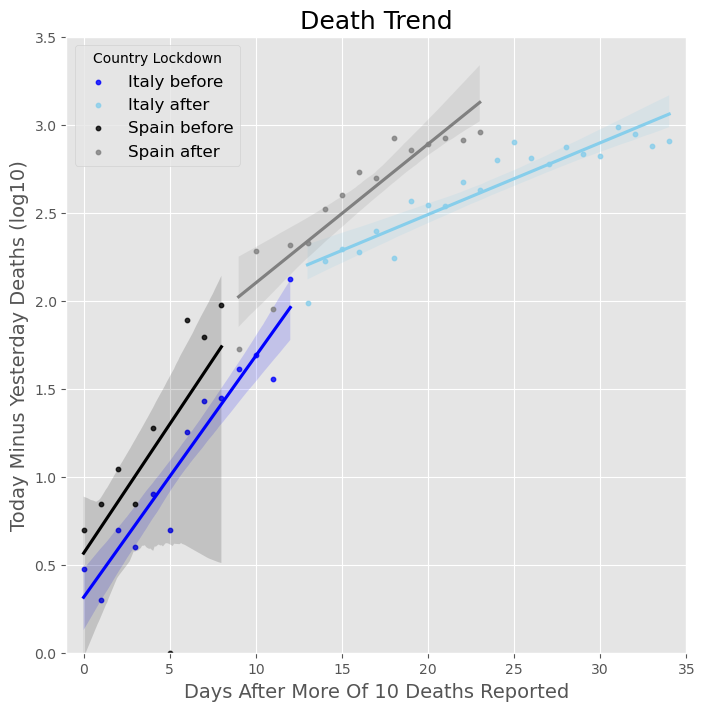

In [99]:
_DEATH_START=10

plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before = before[before['deceduti']>=_DEATH_START]

before['ndata']=np.arange(0,before.shape[0])

after = df[df['data']>='2020-03-9']
after['ndata']=np.arange(before.shape[0],before.shape[0]+after.shape[0])



max_list = []


x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="b", data=before,ax=ax,label='Italy before',
            scatter_kws={'s':10,'marker':'X'})
sns.regplot(x=x, y=y, color="skyblue", data=after,ax=ax,label='Italy after',
            scatter_kws={'s':10,'marker':'x'})

max_list.append(after['ndata'].max())

temp = allDf[(allDf['Country/Region']=='Spain')]
spain_df =  get_country_data(temp)
before = spain_df[spain_df['date']<'2020-03-16']
before=before[before['Death']>=_DEATH_START]
before['ndata']=np.arange(0,before.shape[0])

after = spain_df[spain_df['date']>='2020-03-16']
after['ndata']=np.arange(before.shape[0],before.shape[0]+after.shape[0])

x='ndata'
y='Death_change_log'
sns.regplot(x=x, y=y, color="black", data=before,ax=ax,label='Spain before',
            scatter_kws={'s':10,'marker':'x'})
sns.regplot(x=x, y=y, color="gray", data=after,ax=ax,label='Spain after',
            scatter_kws={'s':10,'marker':'x'})

max_list.append(after['ndata'].max())

#_,_=format_x_date(ax)
#plt.xticks(rotation=70,ha='right')
ax.set_xlim(-1,max(max_list)+1)
ax.set_xlabel('Days After More Of {_DEATH_START} Deaths Reported'.format(_DEATH_START=_DEATH_START)
              , fontsize='14')

plt.ylabel('Today Minus Yesterday Deaths (log10)',fontsize='14')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Country Lockdown',fontsize=12)
ax.set_ylim(0,3.5)
plt.savefig('Fig5.png')
plt.show()

In [84]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 344755 bytes to DataVis.html


In [85]:
!git add DataVis*
!git add -u
!git commit -m 'Italy vs Spain lockdown'
!git push -u origin master

[master ba1ce54] change x axis label
 Committer: Michele Tinti <mtinti@ls29490.local>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 10 files changed, 781 insertions(+), 743 deletions(-)
 rewrite DataVis.ipynb (89%)
 rewrite DataVis_files/DataVis_10_0.png (98%)
 rewrite DataVis_files/DataVis_12_0.png (98%)
 rewrite DataVis_files/DataVis_14_0.png (99%)
 rewrite DataVis_files/DataVis_18_0.png (98%)
 rewrite DataVis_files/DataVis_20_0.png (98%)
 rewrite Fig1.png (98%)
 rewrite Fig2.png (99%)
 rewrite Fig3.png (98%)
Counting objects: 17, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (17/17), done.
Writing objects: 10